In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())
print(tf.device('/device:GPU:0'))

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3738963650045204856
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4152360960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7955637484192387554
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
# base_url = "D:/downloads"
# image_path = "/jpeg/train"
# image_path1 = "/HAM10000_images_part_1"
base_url = "D:/"
image_path = "melanoma-data/siim-isic-melanoma-classification/jpeg/train"
image_path1 = "1"
import os
import pandas as pd
print(len(os.listdir(base_url + image_path)))
print(len(os.listdir(base_url + image_path1)))

33126
10015


In [3]:
import csv
import numpy as np
with open(base_url + '/train.csv') as file_name:
    file_read = csv.reader(file_name)
    array = list(file_read)
    np_arr = np.array(array)
print(np_arr[1:,[0,-1]])

with open(base_url + '/HAM10000_metadata.csv') as file_name:
    file_read = csv.reader(file_name)
    array = list(file_read)
    np_arr = np.array(array)
print(np_arr[1:,[1,2]])

[['ISIC_2637011' '0']
 ['ISIC_0015719' '0']
 ['ISIC_0052212' '0']
 ...
 ['ISIC_9999515' '0']
 ['ISIC_9999666' '0']
 ['ISIC_9999806' '0']]
[['ISIC_0027419' 'bkl']
 ['ISIC_0025030' 'bkl']
 ['ISIC_0026769' 'bkl']
 ...
 ['ISIC_0033536' 'akiec']
 ['ISIC_0032854' 'akiec']
 ['ISIC_0032258' 'mel']]


In [4]:
#read in train csv
train = pd.read_csv(base_url + 'train.csv')

#check for any missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

#fill missing anatom site values with "unknown or other"
train.anatom_site_general_challenge.fillna('other or unknown', inplace=True)

#drop all rows from the train dataframe that are associated with 3 patients who are missing some data.
train.drop(train[(train['patient_id'] == 'IP_0550106') | (train['patient_id'] == 'IP_5205991') |(train['patient_id'] == 'IP_9835712')].index, inplace=True)

#check for any more missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

data = train

n_pos = len(data[data['target']==1])
print('number of images in full train set: {}'.format(len(data)))
print('Number of positive images in subset of train set: {}'.format(n_pos))
print('Percentage of positive images in subset train set: {:.1%}'.format(n_pos/len(data)))
print('Number of negative images in subset train set: {}'.format(len(data) - n_pos))
print('Percentage of negative images in subset train set: {:.1%}'.format(1 - n_pos/len(data)))


image_name missing values: 0
patient_id missing values: 0
sex missing values: 65
age_approx missing values: 68
anatom_site_general_challenge missing values: 527
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0
image_name missing values: 0
patient_id missing values: 0
sex missing values: 0
age_approx missing values: 0
anatom_site_general_challenge missing values: 0
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0
number of images in full train set: 33058
Number of positive images in subset of train set: 584
Percentage of positive images in subset train set: 1.8%
Number of negative images in subset train set: 32474
Percentage of negative images in subset train set: 98.2%


In [5]:
#zmenime typ hodnoty s druheho datasetu na typ s prveho datasetu aby sme mohli potom dva datasety spojit
train1 = pd.read_csv(base_url + 'HAM10000_metadata.csv')
data1 = train1

malign_data1 = data1[data1['dx']=='mel'].to_numpy()[1:,[1,2]]
benign_data1 = data1[data1['dx']=='nv'].to_numpy()[1:,[1,2]]
#print(malign_data)
#print(benign_data)
#print(malign_data[1:,1])
#print(malign_data)
#print(malign_data[0][1])
malign_data1[0][1] = 1
benign_data1[0][1] = 0
for cislo in range(len(malign_data1[1:,1])):
    if malign_data1[1:,1][cislo-1] == 'mel':
        malign_data1[1:,1][cislo-1] = 1

for cislo in range(len(benign_data1[1:,1])):
    if benign_data1[1:,1][cislo] == 'nv':
        benign_data1[1:,1][cislo] = 0

print(malign_data1, '\n')
print(benign_data1)

[['ISIC_0030623' 1]
 ['ISIC_0027190' 1]
 ['ISIC_0031023' 1]
 ...
 ['ISIC_0032936' 1]
 ['ISIC_0033232' 1]
 ['ISIC_0032258' 1]] 

[['ISIC_0024693' 0]
 ['ISIC_0032212' 0]
 ['ISIC_0025775' 0]
 ...
 ['ISIC_0032221' 0]
 ['ISIC_0030693' 0]
 ['ISIC_0031649' 0]]


In [6]:
train = pd.read_csv(base_url + 'train.csv')
data = train
malign_data = data[data['target']==1].to_numpy()[1:,[0,-1]]
benign_data = data[data['target']==0].to_numpy()
idx_x = np.random.choice(len(benign_data),int(len(benign_data)),replace=False)
benign_data = np.array(benign_data[idx_x])

benign_data = benign_data[:len(malign_data)+1]
benign_data = benign_data[1:,[0,-1]]
print(benign_data.size)
print(malign_data.size)

for item in benign_data:
    item[0] = base_url + image_path + '/' + item[0]
for item in malign_data:
    item[0] = base_url + image_path + '/' + item[0]
for item in benign_data1:
    item[0] = base_url + image_path1 + '/' + item[0]
for item in malign_data1:
    item[0] = base_url + image_path1 + '/' + item[0]

benign_data = np.concatenate([benign_data, benign_data1])
malign_data = np.concatenate([malign_data, malign_data1])

print(benign_data)
print(malign_data)

benign_data = benign_data[:1695]
#malign_data = malign_data[:1500]

print(len(benign_data))
print(len(malign_data))



#benign_data = benign_data.reshape(583 , 2) + benign_data1.reshape(6704, 2)
#malign_data = malign_data + malign_data1

#print(benign_data)
#print(malign_data)
#print(len(benign_data))
#print(len(malign_data))


1166
1166
[['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_3490088'
  0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_4033676'
  0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_0458106'
  0]
 ...
 ['D:/1/ISIC_0032221' 0]
 ['D:/1/ISIC_0030693' 0]
 ['D:/1/ISIC_0031649' 0]]
[['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_0188432'
  1]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_0207268'
  1]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_0232101'
  1]
 ...
 ['D:/1/ISIC_0032936' 1]
 ['D:/1/ISIC_0033232' 1]
 ['D:/1/ISIC_0032258' 1]]
1695
1695


In [7]:
shuffle_benign = np.random.choice(len(benign_data),int(len(benign_data)),replace=False)
shuffle_malign = np.random.choice(len(malign_data),int(len(malign_data)),replace=False)
idx_train_benign = shuffle_benign[:int(len(shuffle_benign)*0.70)]
idx_test_benign = shuffle_benign[int(len(shuffle_benign)*0.70):int(len(shuffle_benign)*0.85)]
idx_valid_benign = shuffle_benign[int(len(shuffle_benign)*0.85):int(len(shuffle_benign)*1)]
idx_train_malign = shuffle_malign[:int(len(shuffle_malign)*0.70)]
idx_test_malign = shuffle_malign[int(len(shuffle_malign)*0.70):int(len(shuffle_benign)*0.85)]
idx_valid_malign = shuffle_malign[int(len(shuffle_malign)*0.85):int(len(shuffle_benign)*1)]

train_data_benign = benign_data[idx_train_benign]
test_data_benign = benign_data[idx_test_benign]
valid_data_benign = benign_data[idx_valid_benign]

train_data_malign = malign_data[idx_train_malign]
test_data_malign = malign_data[idx_test_malign]
valid_data_malign = malign_data[idx_valid_malign]
print(len(train_data_benign))
print(len(train_data_malign))
print(len(test_data_benign))
print(len(test_data_malign))
print(len(valid_data_malign))
print(len(valid_data_malign))

1186
1186
254
254
255
255


In [8]:
train_data = np.concatenate((train_data_benign, train_data_malign), axis=0)
test_data = np.concatenate((test_data_benign, test_data_malign), axis=0)
valid_data = np.concatenate((valid_data_benign, valid_data_malign), axis=0)

shuffle_train = np.random.choice(len(train_data),int(len(train_data)),replace=False)
shuffle_test = np.random.choice(len(test_data),int(len(test_data)),replace=False)
shuffle_valid = np.random.choice(len(valid_data),int(len(valid_data)),replace=False)

train_data = train_data[shuffle_train]
test_data = train_data[shuffle_test]
valid_data = train_data[shuffle_valid]
print(train_data)
print(test_data)
print(valid_data)

[['D:/1/ISIC_0029132' 0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_0660770'
  0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_3065032'
  1]
 ...
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_1327515'
  0]
 ['D:/1/ISIC_0029642' 1]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_6289684'
  0]]
[['D:/1/ISIC_0024322' 0]
 ['D:/1/ISIC_0028862' 0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_3562968'
  0]
 ...
 ['D:/1/ISIC_0032149' 1]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_6539127'
  1]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_7662910'
  1]]
[['D:/1/ISIC_0032559' 1]
 ['D:/1/ISIC_0029033' 1]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_8888087'
  0]
 ...
 ['D:/1/ISIC_0029081' 1]
 ['D:/1/ISIC_0030282' 0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_7662910'
  1]]


In [9]:
import cv2
import matplotlib.pyplot as plt

In [15]:
shapes = []
for img in train_data:
    shapes.append(np.shape(cv2.imread(img[0] + '.jpg')))
#print(shapes)

In [18]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())
print(tf.device('/device:GPU:0'))

ModuleNotFoundError: No module named 'tensorflow.python'

array([[<AxesSubplot: title={'center': '0'}>,
        <AxesSubplot: title={'center': '1'}>],
       [<AxesSubplot: title={'center': '2'}>, <AxesSubplot: >]],
      dtype=object)

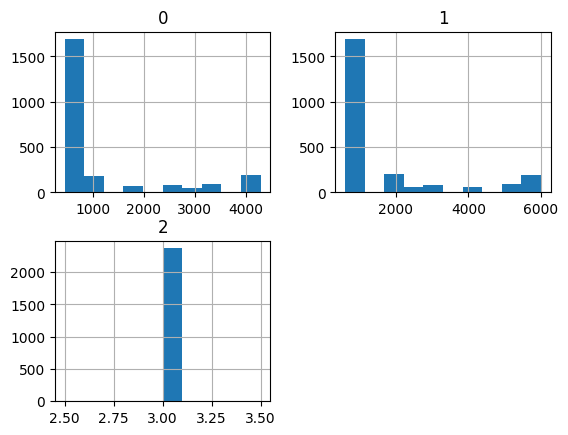

In [19]:
df = pd.DataFrame(data = shapes)
df.hist()

ModuleNotFoundError: No module named 'tensorflow.python'

In [10]:
import math

In [11]:
train_data[:,1]

array([0, 0, 1, ..., 0, 1, 0], dtype=object)

In [20]:
import imgaug.augmenters as iaa
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

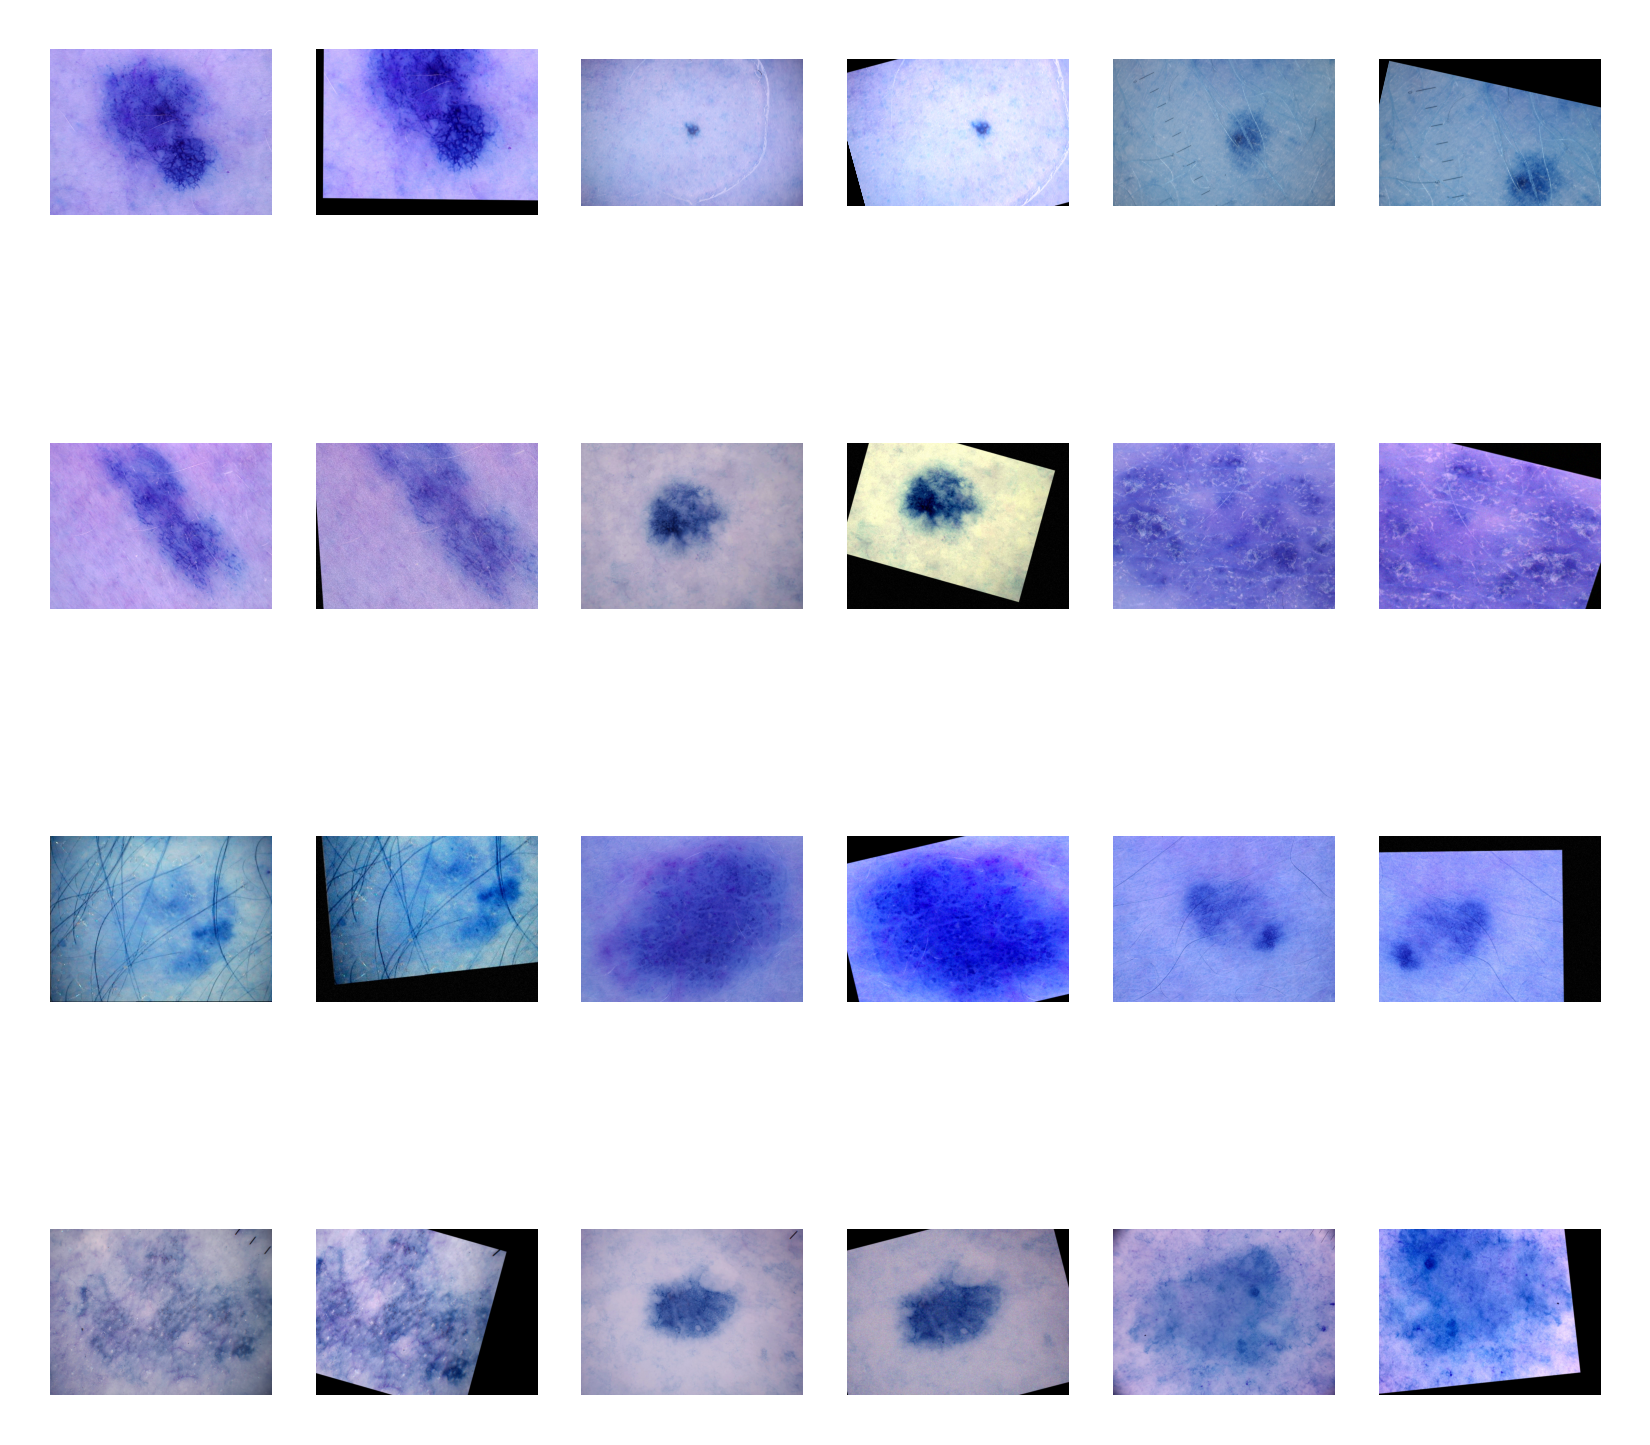

In [21]:
ind_x = 11
ind_y = 10
fig=plt.figure(figsize=(4,8), dpi= 500)
rows = 8
columns = 6
image = cv2.imread(train_data[1][0] + '.jpg')
for i in range(12):
    img_original = cv2.imread(train_data[i][0] + '.jpg')
    result = seq(images = [img_original])[0]
    fig.add_subplot(rows, columns, (2*(i+1)-1), label='original')
    plt.imshow(img_original)
    plt.axis('off')
    fig.add_subplot(rows, columns, (2*(i+1)), label='inverted')
    plt.imshow(result)
    plt.axis('off')

In [30]:
class Generator(tf.keras.utils.Sequence ):

    def __init__(self, paths, labels, batch_size):
        self.paths, self.labels, self.batch_size = paths, labels, batch_size
        self.sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # horizontal flips
            iaa.Crop(percent=(0, 0.1)), # random crops
            # Small gaussian blur with random sigma between 0 and 0.5.
            # But we only blur about 50% of all images.
            iaa.Sometimes(
                0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            # Strengthen or weaken the contrast in each image.
            iaa.LinearContrast((0.75, 1.5)),
            # Add gaussian noise.
            # For 50% of all images, we sample the noise once per pixel.
            # For the other 50% of all images, we sample the noise per pixel AND
            # channel. This can change the color (not only brightness) of the
            # pixels.
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            # Make some images brighter and some darker.
            # In 20% of all cases, we sample the multiplier once per channel,
            # which can end up changing the color of the images.
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            # Apply affine transformations to each image.
            # Scale/zoom them, translate/move them, rotate them and shear them.
            iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-25, 25),
                shear=(-8, 8)
            )
        ], random_order=True) # apply augmenters in random order


    def __len__(self):
        return math.ceil(len(self.paths) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        

        batch_x = [self.__augment(self.hair_remove(cv2.resize(cv2.imread( x + '.jpg'), (256 , 256 )).reshape((256,256,3)))) for x in batch_x]
        batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=2)


    
        return np.array(batch_x), np.array(batch_y)
    def hair_remove(self, image):
    #convert image to greyscale
        grayScale = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
        #kernel for morphologyEx
        kernel = cv2.getStructuringElement(1,(17,17))
    
    #apply MORPH_Blackhat to grayscale image
        blackhat = cv2.morphologyEx(grayScale,cv2.MORPH_BLACKHAT,kernel)
    #apply thresholding to blackhat
        _, threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    #inpaint with original image and threshold image
        final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    
        return final_image
    def __augment(self, images):
        result = self.seq(images=images)
        return result




train_gen = Generator(train_data[:,0], train_data[:,1], 64)
test_gen = Generator(test_data[:,0], test_data[:,1], 64)
valid_gen = Generator(valid_data[:,0], valid_data[:,1], 64)
print('done')
print(train_data[:,0])

done
['D:/1/ISIC_0029132'
 'D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_0660770'
 'D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_3065032'
 ...
 'D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_1327515'
 'D:/1/ISIC_0029642'
 'D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_6289684']


In [23]:
from tensorflow.keras import layers, models

In [24]:
resnet_model = models.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(254, activation='relu'))
resnet_model.add(layers.Dense(128, activation='relu'))
resnet_model.add(layers.Dense(2, activation='softmax'))


In [25]:
resnet_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

# tf.keras.utils.plot_model(resnet_model)
print('done')

done


In [26]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="first/future-feri-16-12-2022.hdf5",
        #     save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

In [31]:
history = resnet_model.fit(train_gen, validation_data=test_gen, epochs=7, callbacks=[model_checkpoint_callback])
print('done')

Epoch 1/7
38/38 [==============================] - 601s 16s/step - loss: 0.7066 - accuracy: 0.5982 - val_loss: 0.6111 - val_accuracy: 0.6890
Epoch 2/7
38/38 [==============================] - 582s 15s/step - loss: 0.5886 - accuracy: 0.6977 - val_loss: 0.5642 - val_accuracy: 0.7028
Epoch 3/7
38/38 [==============================] - 585s 15s/step - loss: 0.6024 - accuracy: 0.6834 - val_loss: 0.5543 - val_accuracy: 0.7224
Epoch 4/7
38/38 [==============================] - 581s 15s/step - loss: 0.5509 - accuracy: 0.7277 - val_loss: 0.5422 - val_accuracy: 0.7264
Epoch 5/7
38/38 [==============================] - 600s 16s/step - loss: 0.5404 - accuracy: 0.7331 - val_loss: 0.5252 - val_accuracy: 0.7480
Epoch 6/7
38/38 [==============================] - 603s 16s/step - loss: 0.5628 - accuracy: 0.7201 - val_loss: 0.5544 - val_accuracy: 0.7480
Epoch 7/7
38/38 [==============================] - 594s 16s/step - loss: 0.5588 - accuracy: 0.7154 - val_loss: 0.5640 - val_accuracy: 0.7146
done


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


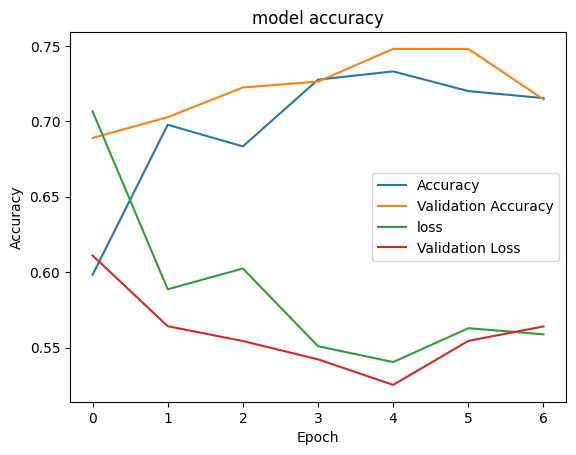

In [32]:
print(history.history.keys())
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [33]:
resnet_model.summary()
#url = "D:/downloads/HAM10000_images_part_1/ISIC_0027315.jpg"
#url = "D:/downloads/HAM10000_images_part_1/ISIC_0024698.jpg"
url = "D:/downloads/HAM10000_images_part_1/ISIC_0029081.jpg"
#img = cv2.imread(url)
img = cv2.resize(cv2.imread(url), (256 , 256 )).reshape((256,256,3))
#print(img)
l = np.array([img])
#l = np.expand_dims(img, axis=0)
print(l)
#img1 = cv2.imread(l)
result = resnet_model.predict(l)
print(result)
print(np.argmax(result))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 254)               520446    
                                                                 
 dense_1 (Dense)             (None, 128)               32640     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 24,141,056
Trainable params: 553,344
Non-trainable params: 23,587,712
_________________________________________________________________


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [24]:
import cv2